<a href="https://colab.research.google.com/github/Nachos-mic/Rotten_Review_Model/blob/main/EDT_Rotten_Review_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Movie Review Analysis Pipeline
IMDB Sentiment Model + Rotten Tomatoes Fake/Biased Review Detection


TRENING MODELU 1 - IMDB SENTYMENT

In [2]:
!pip install contractions -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.3 MB/s eta 0:00:00


In [26]:
# ========================================
# IMPORTS & SETUP
# ========================================
import pandas as pd
import numpy as np
import re
import string
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.corpus import wordnet

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import contractions
from bs4 import BeautifulSoup
import kagglehub
import os

# NLTK downloads
for resource in ['punkt', 'stopwords', 'wordnet', 'punkt_tab', 'averaged_perceptron_tagger', 'averaged_perceptron_tagger_eng']:
    nltk.download(resource, quiet=True)

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

In [4]:
# ========================================
# PART 1: IMDB SENTIMENT MODEL
# ========================================
print("="*60)
print("PART 1: TRAINING IMDB SENTIMENT MODEL")
print("="*60)

# Text Cleaning Functions
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

def expand_contractions(text):
    return contractions.fix(text)

def to_lowercase(text):
    return text.lower()

def remove_special_characters(text):
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    return text

def remove_extra_spaces(text):
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def remove_stopwords_and_lemmatize(text):
    tokens = word_tokenize(text)
    tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in stop_words and len(token) > 2
    ]
    return " ".join(tokens)

def clean_text(text):
    """IMDB cleaning pipeline"""
    text = remove_html_tags(text)
    text = expand_contractions(text)
    text = to_lowercase(text)
    text = remove_special_characters(text)
    text = remove_extra_spaces(text)
    text = remove_stopwords_and_lemmatize(text)
    return text

PART 1: TRAINING IMDB SENTIMENT MODEL


In [5]:
# Load IMDB Dataset
print("\n📥 Loading IMDB dataset...")
dataset_path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
csv_path = os.path.join(dataset_path, "IMDB Dataset.csv")
df_imdb = pd.read_csv(csv_path)

print(f"✅ Loaded {len(df_imdb)} IMDB reviews")
print(f"Sentiment distribution:\n{df_imdb['sentiment'].value_counts()}")


📥 Loading IMDB dataset...
Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
✅ Loaded 50000 IMDB reviews
Sentiment distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [ ]:
# Clean and prepare
df_imdb['review'] = df_imdb['review'].apply(clean_text)
label_mapping = {'positive': 1, 'negative': -1}
df_imdb['sentiment_num'] = df_imdb['sentiment'].map(label_mapping)

In [7]:
# Display basic information
print(f"\n📊 Dataset Shape: {df_imdb.shape}")
print(f"📝 Columns: {df_imdb.columns.tolist()}")
print(f"\n🎬 Dataset Preview:")
df_imdb.head()


📊 Dataset Shape: (50000, 3)
📝 Columns: ['review', 'sentiment', 'sentiment_num']

🎬 Dataset Preview:


,review,sentiment,sentiment_num
0,one reviewer mentioned watching episode hooked...,positive,1
1,wonderful little production filming technique ...,positive,1
2,thought wonderful way spend time hot summer we...,positive,1
3,basically family little boy jake think zombie ...,negative,-1
4,petter mattei love time money visually stunnin...,positive,1


In [9]:
# Check for missing values and basic statistics
print("🔍 Dataset Information:")
print("="*50)
print(f"Total reviews: {len(df_imdb)}")
print(f"Missing values: {df_imdb.isnull().sum().sum()}")
print(f"\nSentiment Distribution:")
print(df_imdb['sentiment'].value_counts())
print("\n📏 Review Length Statistics:")
df_imdb['review_length'] = df_imdb['review'].str.len()
print(f"Average length: {df_imdb['review_length'].mean():.0f} characters")
print(f"Shortest review: {df_imdb['review_length'].min()} characters")
print(f"Longest review: {df_imdb['review_length'].max()} characters")

🔍 Dataset Information:
Total reviews: 50000
Missing values: 0

Sentiment Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

📏 Review Length Statistics:
Average length: 797 characters
Shortest review: 17 characters
Longest review: 9038 characters


In [10]:
# Train sentiment model
print("\n🤖 Training Logistic Regression model...")
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_imdb['review'])
y = df_imdb['sentiment_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


🤖 Training Logistic Regression model...


LogisticRegression(max_iter=1000)

In [11]:
y_pred = model.predict(X_test)
print(f"\n✅ Model Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


✅ Model Accuracy: 0.8827

Classification Report:
              precision    recall  f1-score   support

          -1       0.89      0.88      0.88      4961
           1       0.88      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [12]:
def predict_sentiment(review_text):
    """Predict sentiment: 1 (positive) or -1 (negative)"""
    cleaned = clean_text(review_text)
    vector = vectorizer.transform([cleaned])
    return model.predict(vector)[0]

# MODEL 2 - BIAS ROTTEN TOMATOES

EDA & PREPROCESSING

In [13]:
# ========================================
# PART 2: ROTTEN TOMATOES DATA LOADING
# ========================================
print("\n" + "="*60)
print("PART 2: LOADING ROTTEN TOMATOES DATA")
print("="*60)

dataset_path_rt = kagglehub.dataset_download(
    "stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset"
)

movies_csv = os.path.join(dataset_path_rt, "rotten_tomatoes_movies.csv")
reviews_csv = os.path.join(dataset_path_rt, "rotten_tomatoes_critic_reviews.csv")

movies_df = pd.read_csv(movies_csv)
reviews_df = pd.read_csv(reviews_csv)

print(f"\n📊 Movies: {movies_df.shape}")
print(f"📊 Reviews: {reviews_df.shape}")


PART 2: LOADING ROTTEN TOMATOES DATA


100%|██████████| 77.2M/77.2M [00:00<00:00, 88.1MB/s]

Extracting files...



📊 Movies: (17712, 22)
📊 Reviews: (1130017, 8)


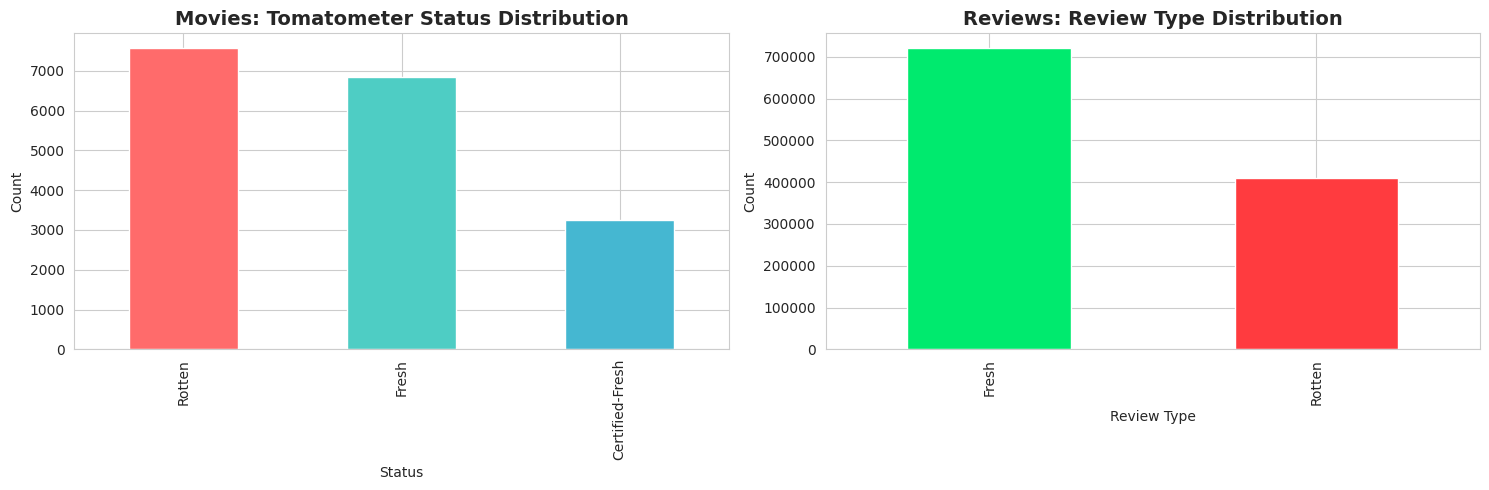

In [16]:
# Analiza rozkładu sentiment/review_type
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

if 'tomatometer_status' in movies_df.columns:
    movies_df['tomatometer_status'].value_counts().plot(kind='bar', ax=axes[0], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    axes[0].set_title('Movies: Tomatometer Status Distribution', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Status')
    axes[0].set_ylabel('Count')

if 'review_type' in reviews_df.columns:
    reviews_df['review_type'].value_counts().plot(kind='bar', ax=axes[1], color=['#00EA6E', '#FF3B3F'])
    axes[1].set_title('Reviews: Review Type Distribution', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Review Type')
    axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [17]:
reviews_df['review_score'].dropna().unique()


array(['3.5/5', '1/4', 'B', '3/5', '4/5', '2/4', '2/5', 'C', '2.5/4',
       '3/4', 'C-', '2.75/5', 'B-', '2.5/5', '5.5/10', '1/5', 'C+', 'D+',
       '1.5/4', '6.5/10', '3/10', '1.5/5', '4/10', '7/10', '6/10', 'B+',
       '5/5', 'A-', '4.5/5', '5.78/10', '3.5/4', 'A', '9/10', '8.5/10',
       '4/4', '83/100', '8/10', '92/100', '82/100', '84/100', '10/10',
       'D-', 'F', '0.5/4', 'D', '5/10', '2/10', '2/6', '0.5/5', '0/4',
       '0/5', '76/100', '87/100', '74/100', '86/100', '81/100', '56/100',
       '78/100', '2.25/5', '8.8/10', '0/10', '44/100', '2.75/4', '2.4/5',
       '8.6/10', '79/100', '68/100', '80/100', '90/100', '66/100',
       '91/100', '0.3/5', '9.2/10', '2.7/5', '57/100', '4/6', '3/6',
       '73/100', '42/100', '65/100', '7.5/10', '4.5/10', '5/6', '1/6',
       '70/100', '3.5/10', '71/100', '0.1/5', '3.25/10', '89/100',
       '40/100', '64/100', '62/100', '1/10', '3.75/5', '37/100', '49/100',
       '60/100', '3.3/5', '77/100', '5.25/10', '1.4/4', '75/100', '1.5/6

In [15]:
# ========================================
# EDA 1: Initial Data Exploration
# ========================================
print("\n" + "="*60)
print("EDA 1: INITIAL DATA QUALITY CHECK")
print("="*60)

print("\n🔍 Reviews Dataset:")
print(f"  Total reviews: {len(reviews_df)}")
print(f"  Missing values:\n{reviews_df.isnull().sum()[reviews_df.isnull().sum() > 0]}")
print(f"\n  Top Critic Distribution:")
print(reviews_df['top_critic'].value_counts(dropna=False))

print("\n🔍 Movies Dataset:")
print(f"  Total movies: {len(movies_df)}")
# Convert 'original_release_date' to datetime, coercing errors
movies_df['original_release_date'] = pd.to_datetime(movies_df['original_release_date'], errors='coerce')
print(f"  Date range: {movies_df['original_release_date'].min()} to {movies_df['original_release_date'].max()}")


EDA 1: INITIAL DATA QUALITY CHECK

🔍 Reviews Dataset:
  Total reviews: 1130017
  Missing values:
critic_name        18529
review_score      305936
review_content     65806
dtype: int64

  Top Critic Distribution:
top_critic
False    841481
True     288536
Name: count, dtype: int64

🔍 Movies Dataset:
  Total movies: 17712
  Date range: 1914-06-01 00:00:00 to 2020-09-30 00:00:00


In [18]:
# ========================================
# PREPROCESSING 1: Filter Top Critics Only
# ========================================
print("\n" + "="*60)
print("PREPROCESSING 1: FILTERING TOP CRITICS")
print("="*60)

original_count = len(reviews_df)
reviews_df = reviews_df[reviews_df['top_critic'] == True].copy()
print(f"✂️ Filtered from {original_count} to {len(reviews_df)} reviews (top critics only)")
print(f"   Kept {len(reviews_df)/original_count*100:.1f}% of data")


PREPROCESSING 1: FILTERING TOP CRITICS
✂️ Filtered from 1130017 to 288536 reviews (top critics only)
   Kept 25.5% of data


In [19]:
reviews_df['review_score'].dropna().unique()


array(['3.5/5', '3/5', '2/4', '2/5', '3/4', 'C-', '2.5/4', 'C+', 'D+',
       '1/5', 'C', '4/5', 'A-', '4.5/5', '3.5/4', 'A', '1.5/4', '4/4',
       'B', '5/5', '1.5/5', '1/4', 'D', 'F', '2/6', 'B-', '0/4', 'B+',
       'D-', '2.5/5', '0.5/4', '0/5', '2.4/5', '4/6', '3/6', '5/10',
       '5/6', '1/6', '5.5/10', '7/10', '8/10', '6/10', '3/10', '8.5/10',
       '5.9/10', '4.6/10', '3.4/10', '10/10', '0.5/5', '35/100', '1/3',
       '42/100', '9/10', '55/100', '80/100', '78/100', '94/100', '5/100',
       '75/100', '50/100', '30/100', '62/100', '52/100', '3', '2/2',
       '4/10', '3.5/6', '7.5/10', '6.4/10', '4.5/10', '45/100', '70/100',
       '2.5/10', '68/100', '15/100', '0', '0.5/10', '2', '0/6', '0/10',
       '1/10', '8.3/10', '8.1/10', '3.5/10', '1.2/10', '5.2/10', '6.5/10',
       '6.2/10', '47/100', '4.2/10', '9.1/10', '20/100', '7.2/10',
       '40/100', '85/100', '5', '10/100', '90/100', '4.8/10', '41/100',
       '6.8/10', '6.6/10', '5.3/10', '3/3', '8.6/10', '6.3/10', '8.7/1

In [20]:
# ========================================
# PREPROCESSING 2: Merge Datasets
# ========================================
print("\n" + "="*60)
print("PREPROCESSING 2: MERGING REVIEWS WITH MOVIES")
print("="*60)

# Select relevant movie columns
movie_cols = ['rotten_tomatoes_link', 'original_release_date', 'tomatometer_rating',
              'tomatometer_status', 'audience_rating', 'audience_status', 'movie_title']
movies_subset = movies_df[movie_cols].copy()

# Merge
df = reviews_df.merge(movies_subset, on='rotten_tomatoes_link', how='left')
print(f"✅ Merged dataset: {df.shape}")
print(f"   Merge success rate: {(1 - df['original_release_date'].isna().sum()/len(df))*100:.1f}%")


PREPROCESSING 2: MERGING REVIEWS WITH MOVIES
✅ Merged dataset: (288536, 14)
   Merge success rate: 98.2%


In [22]:
# ========================================
# EDA 2: Text Quality Analysis
# ========================================
print("\n" + "="*60)
print("EDA 2: TEXT CONTENT ANALYSIS")
print("="*60)

# Sample reviews to check for artifacts
sample_reviews = df['review_content'].dropna().head(10)
print("\n📝 Sample review (first 200 chars):")
print(sample_reviews.iloc[0][:200])

# Check for HTML tags
html_pattern = re.compile('<.*?>')
has_html = df['review_content'].str.contains(html_pattern, na=False).sum()
print(f"\n🔍 Reviews with HTML tags: {has_html}")

# Check for URLs
url_pattern = re.compile(r'https?://\S+|www\.\S+')
has_urls = df['review_content'].str.contains(url_pattern, na=False).sum()
print(f"🔍 Reviews with URLs: {has_urls}")

# Text length distribution
df['review_length_raw'] = df['review_content'].str.len()
print(f"\n📏 Review length stats:")
print(df['review_length_raw'].describe())


EDA 2: TEXT CONTENT ANALYSIS

📝 Sample review (first 200 chars):
What's really lacking in The Lightning Thief is a genuine sense of wonder, the same thing that brings viewers back to Hogwarts over and over again.

🔍 Reviews with HTML tags: 0
🔍 Reviews with URLs: 12

📏 Review length stats:
count    280638.000000
mean        129.424044
std          55.675716
min           4.000000
25%          87.000000
50%         128.000000
75%         170.000000
max         257.000000
Name: review_length_raw, dtype: float64


In [23]:
# ========================================
# PREPROCESSING 3: Text Cleaning
# ========================================
print("\n" + "="*60)
print("PREPROCESSING 3: CLEANING TEXT CONTENT")
print("="*60)

CHAT_WORDS = {
    "AFAIK": "As Far As I Know", "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible", "BTW": "By The Way",
    "FYI": "For Your Information", "IMHO": "In My Honest Opinion",
    "IMO": "In My Opinion", "LOL": "Laughing Out Loud",
    "OMG": "Oh My God", "TBH": "To Be Honest"
}

def remove_urls(text):
    if not isinstance(text, str):
        return ''
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def remove_emoji(text):
    if not isinstance(text, str):
        return ''
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub('', text)

def expand_chat_words(text):
    if not isinstance(text, str):
        return ''
    words = text.split()
    expanded = [CHAT_WORDS.get(word.upper(), word) for word in words]
    return ' '.join(expanded)

def remove_punctuation(text):
    if not isinstance(text, str):
        return ''
    return text.translate(str.maketrans('', '', string.punctuation))

def clean_text_rt(text):
    """Rotten Tomatoes cleaning pipeline"""
    if not isinstance(text, str) or not text.strip():
        return ''

    text = remove_html_tags(text)
    text = remove_urls(text)
    text = remove_emoji(text)
    text = expand_chat_words(text)
    text = text.lower()
    text = remove_punctuation(text)
    text = remove_extra_spaces(text)

    return text

print("🧹 Cleaning review content...")
df['text_cleaned'] = df['review_content'].apply(clean_text_rt)

empty_after_cleaning = (df['text_cleaned'].str.strip() == '').sum()
print(f"✅ Cleaned {len(df)} reviews")
print(f"   Empty after cleaning: {empty_after_cleaning}")


PREPROCESSING 3: CLEANING TEXT CONTENT
🧹 Cleaning review content...
✅ Cleaned 288536 reviews
   Empty after cleaning: 7904


In [24]:
# ========================================
# EDA 3: Post-Cleaning Analysis
# ========================================
print("\n" + "="*60)
print("EDA 3: POST-CLEANING QUALITY CHECK")
print("="*60)

df['text_length_cleaned'] = df['text_cleaned'].str.len()
print("📏 Cleaned text length distribution:")
print(df['text_length_cleaned'].describe())

print("\n📝 Sample cleaned review:")
print(df['text_cleaned'].iloc[0][:200])


EDA 3: POST-CLEANING QUALITY CHECK
📏 Cleaned text length distribution:
count    288536.000000
mean        121.739818
std          57.256819
min           0.000000
25%          80.000000
50%         122.000000
75%         164.000000
max         254.000000
Name: text_length_cleaned, dtype: float64

📝 Sample cleaned review:
whats really lacking in the lightning thief is a genuine sense of wonder the same thing that brings viewers back to hogwarts over and over again


In [27]:
# ========================================
# PREPROCESSING 4: Tokenization & Lemmatization
# ========================================
print("\n" + "="*60)
print("PREPROCESSING 4: TOKENIZATION & LEMMATIZATION")
print("="*60)

def get_wordnet_pos(treebank_tag):
    tag_dict = {
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV
    }
    return tag_dict.get(treebank_tag[0], wordnet.NOUN)

def tokenize_and_lemmatize(text, remove_stopwords=True, min_word_length=2):
    if not isinstance(text, str) or not text.strip():
        return []

    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha() and len(word) >= min_word_length]

    if remove_stopwords:
        stop_words_set = set(stopwords.words('english'))
        custom_stopwords = {'film', 'movie', 'movies', 'films', 'scene', 'scenes'}
        stop_words_set.update(custom_stopwords)
        tokens = [word for word in tokens if word not in stop_words_set]

    lemmatizer = WordNetLemmatizer()
    pos_tags = pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(pos))
                  for word, pos in pos_tags]

    return lemmatized

print("🔤 Tokenizing and lemmatizing...")
df['tokens'] = df['text_cleaned'].apply(tokenize_and_lemmatize)
df['token_count'] = df['tokens'].apply(len)
df['tokens_text'] = df['tokens'].apply(lambda x: ' '.join(x))

print(f"✅ Tokenization complete")
print(f"   Avg tokens per review: {df['token_count'].mean():.1f}")
print(f"   Median tokens: {df['token_count'].median():.0f}")


PREPROCESSING 4: TOKENIZATION & LEMMATIZATION
🔤 Tokenizing and lemmatizing...
✅ Tokenization complete
   Avg tokens per review: 11.5
   Median tokens: 11


In [28]:
# ========================================
# PREPROCESSING 5: Date Processing
# ========================================
print("\n" + "="*60)
print("PREPROCESSING 5: DATE FEATURE EXTRACTION")
print("="*60)

df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce')
df['original_release_date'] = pd.to_datetime(df['original_release_date'], errors='coerce')

df['review_year'] = df['review_date'].dt.year
df['review_month'] = df['review_date'].dt.month
df['release_year'] = df['original_release_date'].dt.year

df['days_since_release'] = (df['review_date'] - df['original_release_date']).dt.days

print(f"✅ Date features extracted")
print(f"   Reviews with valid dates: {df['days_since_release'].notna().sum()}")
print(f"   Date range: {df['review_date'].min()} to {df['review_date'].max()}")


PREPROCESSING 5: DATE FEATURE EXTRACTION
✅ Date features extracted
   Reviews with valid dates: 283202
   Date range: 1800-01-01 00:00:00 to 2020-10-27 00:00:00


In [29]:
# ========================================
# EDA 4: Temporal Patterns
# ========================================
print("\n" + "="*60)
print("EDA 4: REVIEW TIMING ANALYSIS")
print("="*60)

early_reviews = (df['days_since_release'] < 7).sum()
print(f"🚨 Early reviews (< 7 days): {early_reviews} ({early_reviews/len(df)*100:.1f}%)")

print("\nDays since release distribution:")
print(df['days_since_release'].describe())


EDA 4: REVIEW TIMING ANALYSIS
🚨 Early reviews (< 7 days): 178789 (62.0%)

Days since release distribution:
count    283202.000000
mean       1075.730193
std        3806.020012
min      -77261.000000
25%          -1.000000
50%           0.000000
75%          49.000000
max       38854.000000
Name: days_since_release, dtype: float64


to tu do wymiany, najważniejsze jest x przed i x po

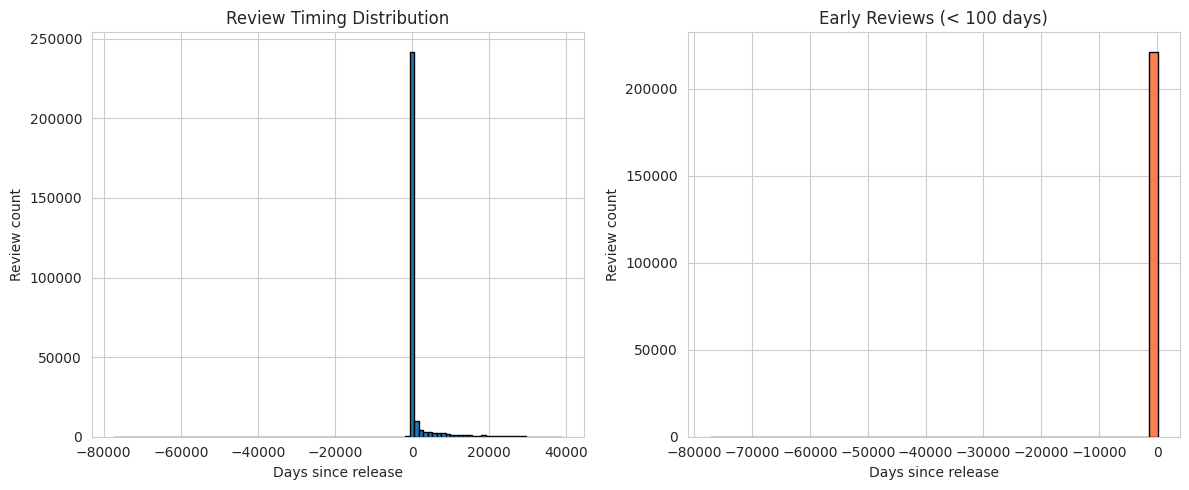

In [30]:
# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df['days_since_release'].hist(bins=100, edgecolor='black')
plt.xlabel("Days since release")
plt.ylabel("Review count")
plt.title("Review Timing Distribution")

plt.subplot(1, 2, 2)
df[df['days_since_release'] < 100]['days_since_release'].hist(bins=50, edgecolor='black', color='coral')
plt.xlabel("Days since release")
plt.ylabel("Review count")
plt.title("Early Reviews (< 100 days)")
plt.tight_layout()
plt.show()

In [31]:
# ========================================
# PREPROCESSING 6: Feature Engineering
# ========================================
print("\n" + "="*60)
print("PREPROCESSING 6: FEATURE ENGINEERING")
print("="*60)

# Categorical encoding
df['review_type_encoded'] = df['review_type'].map({'Fresh': 1, 'Rotten': 0})

# Text features
df['word_count'] = df['text_cleaned'].str.split().str.len()
df['sentence_count'] = df['text_cleaned'].str.count(r'[.!?]') + 1
df['avg_word_length'] = df['text_length_cleaned'] / df['word_count'].replace(0, 1)
df['unique_word_count'] = df['tokens'].apply(lambda x: len(set(x)))
df['lexical_diversity'] = df['unique_word_count'] / df['token_count'].replace(0, 1)

# Behavioral features
df['is_early_review'] = df['days_since_release'] < 7

print("✅ Feature engineering complete")
print(f"   Total features created: text (7) + temporal (5) + categorical (1)")


PREPROCESSING 6: FEATURE ENGINEERING
✅ Feature engineering complete
   Total features created: text (7) + temporal (5) + categorical (1)


In [32]:
# ========================================
# PREPROCESSING 7: Apply IMDB Sentiment
# ========================================
print("\n" + "="*60)
print("PREPROCESSING 7: APPLYING IMDB SENTIMENT MODEL")
print("="*60)

print("🎯 Predicting sentiment for Rotten Tomatoes reviews...")
df['predicted_sentiment'] = df['text_cleaned'].apply(predict_sentiment)

sentiment_dist = df['predicted_sentiment'].value_counts()
print(f"\n✅ Sentiment predictions:")
print(f"   Positive (1): {sentiment_dist.get(1, 0)} ({sentiment_dist.get(1, 0)/len(df)*100:.1f}%)")
print(f"   Negative (-1): {sentiment_dist.get(-1, 0)} ({sentiment_dist.get(-1, 0)/len(df)*100:.1f}%)")


PREPROCESSING 7: APPLYING IMDB SENTIMENT MODEL
🎯 Predicting sentiment for Rotten Tomatoes reviews...

✅ Sentiment predictions:
   Positive (1): 171086 (59.3%)
   Negative (-1): 117450 (40.7%)


In [33]:
# ========================================
# EDA 5: Sentiment vs Review Type
# ========================================
print("\n" + "="*60)
print("EDA 5: SENTIMENT MODEL VALIDATION")
print("="*60)

crosstab = pd.crosstab(
    df['review_type'],
    df['predicted_sentiment'],
    normalize='index'
) * 100

print("\n📊 Predicted Sentiment by Review Type (%):")
print(crosstab.round(1))

# Agreement rate
df['sentiment_matches'] = (
    ((df['review_type'] == 'Fresh') & (df['predicted_sentiment'] == 1)) |
    ((df['review_type'] == 'Rotten') & (df['predicted_sentiment'] == -1))
)
agreement = df['sentiment_matches'].mean() * 100
print(f"\n✅ Agreement rate: {agreement:.1f}%")


EDA 5: SENTIMENT MODEL VALIDATION

📊 Predicted Sentiment by Review Type (%):
predicted_sentiment    -1     1
review_type                    
Fresh                27.0  73.0
Rotten               60.5  39.5

✅ Agreement rate: 67.9%



GENERATING WORD CLOUDS


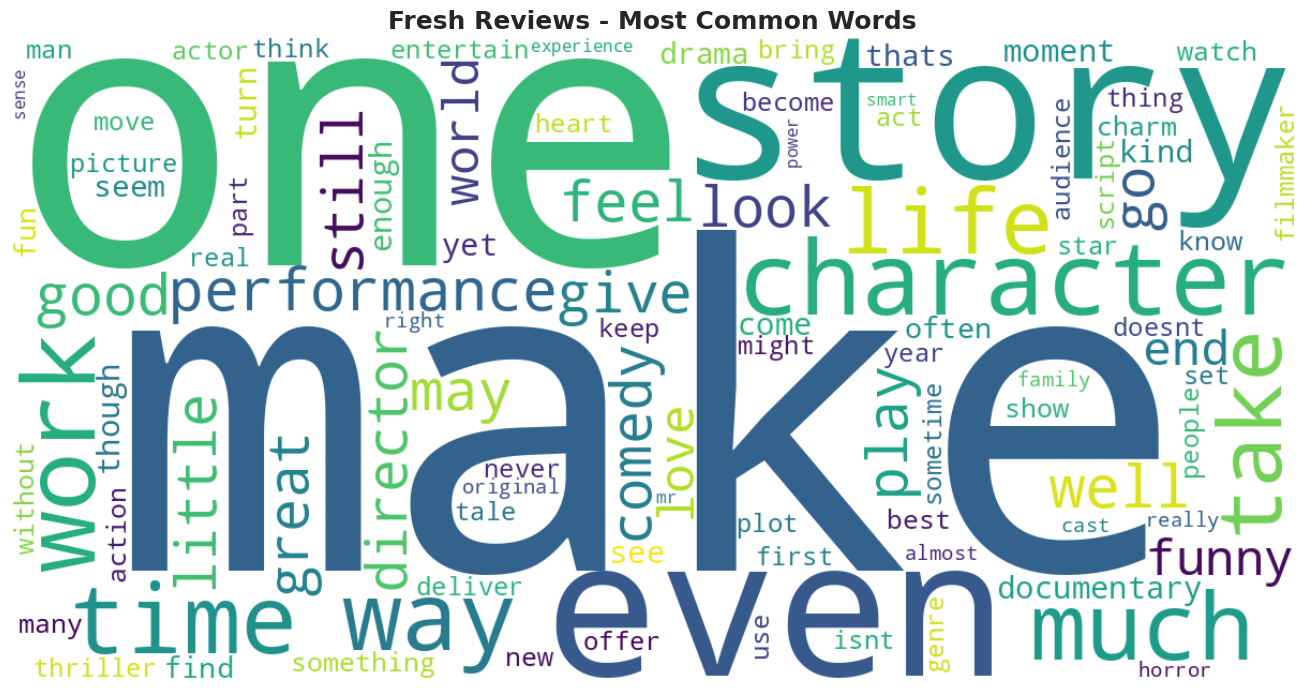

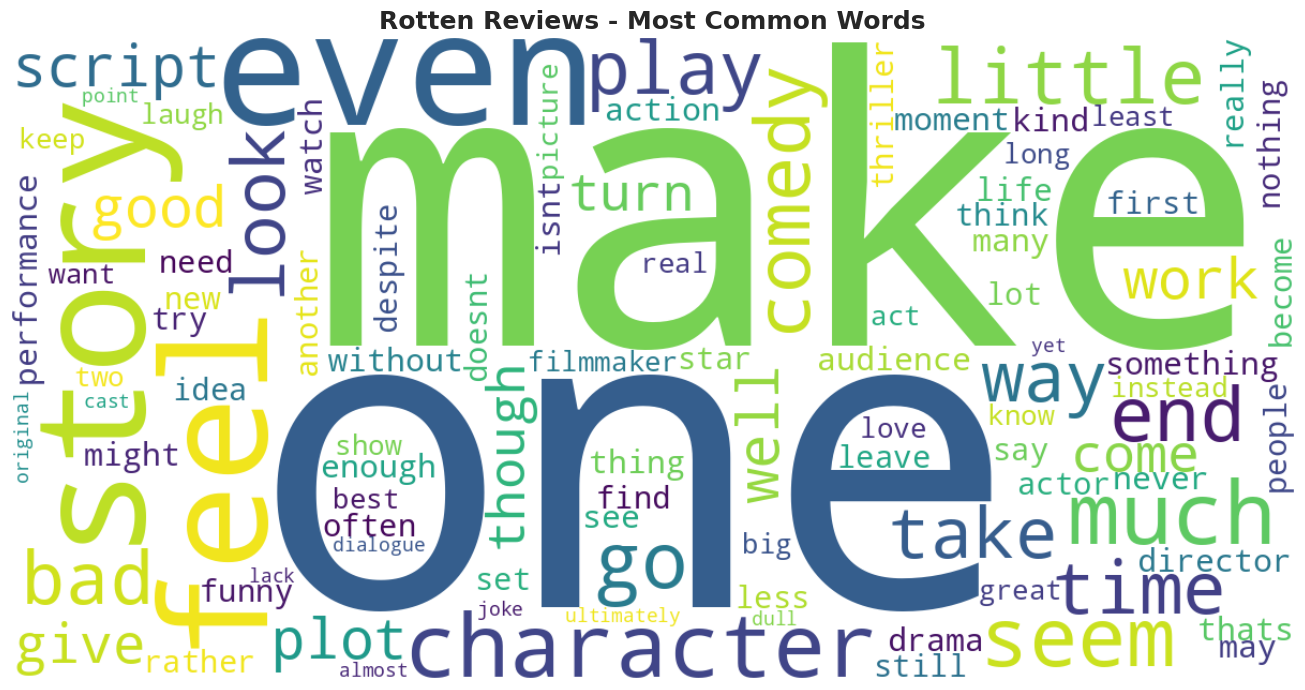

In [34]:
# ========================================
# VISUALIZATION: Word Clouds
# ========================================
print("\n" + "="*60)
print("GENERATING WORD CLOUDS")
print("="*60)

def generate_wordcloud(tokens_series, title):
    all_tokens = [token for tokens in tokens_series for token in tokens]
    if not all_tokens:
        return

    text = ' '.join(all_tokens)
    wordcloud = WordCloud(
        width=1200, height=600,
        background_color='white',
        max_words=100,
        colormap='viridis'
    ).generate(text)

    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=18, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

fresh_reviews = df[df['review_type'] == 'Fresh']
rotten_reviews = df[df['review_type'] == 'Rotten']

generate_wordcloud(fresh_reviews['tokens'], 'Fresh Reviews - Most Common Words')
generate_wordcloud(rotten_reviews['tokens'], 'Rotten Reviews - Most Common Words')

In [37]:
mismatched_df = df[~df['sentiment_matches']]

print(f"❌ Liczba niezgodnych recenzji: {len(mismatched_df)} ({len(mismatched_df)/len(df)*100:.1f}%)")

mismatched_df[['review_type', 'predicted_sentiment', 'text_cleaned']].sample(10)


❌ Liczba niezgodnych recenzji: 92644 (32.1%)


,review_type,predicted_sentiment,text_cleaned
251558,Rotten,1,pitsenbargers story is one worth telling but t...
130272,Fresh,-1,probably enough goodwill has been built up in ...
260017,Fresh,-1,edgertons commitment to precise cinematic lang...
177790,Fresh,-1,as heavy stressful relentlessly sad dramas go ...
128896,Fresh,-1,montage understands cobain as an icon but also...
222836,Fresh,-1,abrams has a gift for making us feel as if sta...
8726,Rotten,1,theres precious little reward in plumbing the ...
235974,Rotten,1,flies off its comic rails after an engaging st...
118809,Fresh,-1,in ip man 3 yen went manoamano with mike tyson...
198484,Rotten,1,it was obviously intended as a comedy but ther...


no ten sentyment działa po chuju